# MetPy Tutorial

![](https://pbs.twimg.com/profile_images/841437284767539200/SqjqHdLv_400x400.jpg)

MetPy is a collection of tools in Python for reading, visualizing, and performing calculations with weather data. It's a high level package that is built on top of familiar libraries such as numpy, matplotlib, pandas and xarray. Let's explore some weather data!

Load up the packages

  **You'll have to install cartopy, metpy, netCDF4, and xarray**

In [185]:
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')


from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage

import xarray as xr

### Revisiting the Cartopy Assignment

Load up the TreeCov dataset

In [53]:
data = xr.open_dataset("Downloads/treecov.nc")

data

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    treecov  (lat, lon) float32 ...
Attributes:
    source:   UMD Tree Cover Data resampled to 0.5-degrees
    data:     gl-latlong-8km-landcover.bsq.gz
    history:  P.J. Bartlein, 20 Feb 2008

#### Now let's use metpy.parse_cf() to parse our desired variable from data

In [47]:
treeData = data.metpy.parse_cf('treecov')

    | Ignore the warning above. It's just saying there is no defined projection but metpy interprets that as lat/lon aka Plate.Carree

#### Now let's read the projection (CRS, or coordinate refernece system) using the metpy.cartopy_crs

In [ ]:
proj = treeData.metpy.cartopy_crs

In [44]:
proj

So, metpy has interpreted the data to be in PlateCarree based on the latitude/longitudes here. This is a great tool to use if you're unsure of a projection that you're data is coming in

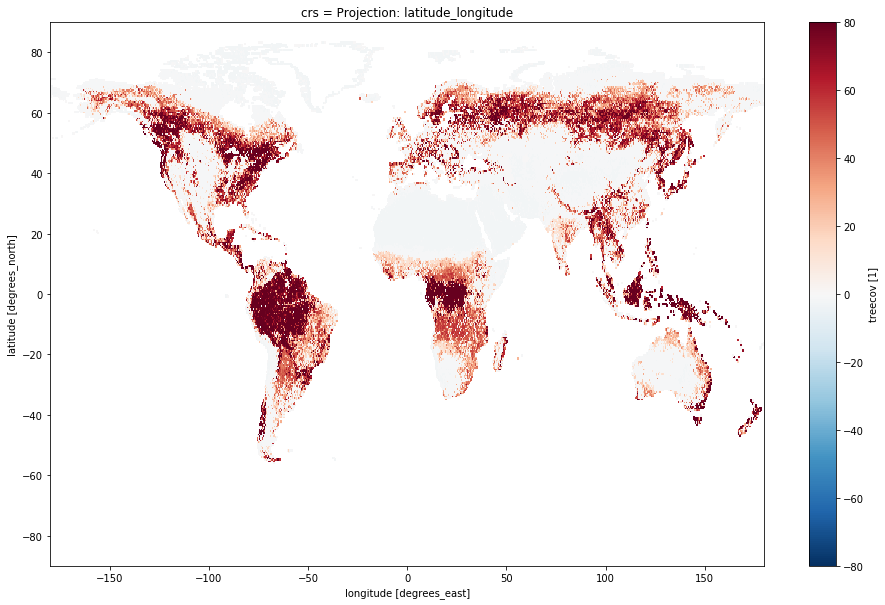

In [51]:
fig = plt.figure(figsize=(16,10))
treeData.plot()

Text(0.5, 1.0, 'Reprojected to Robinson')

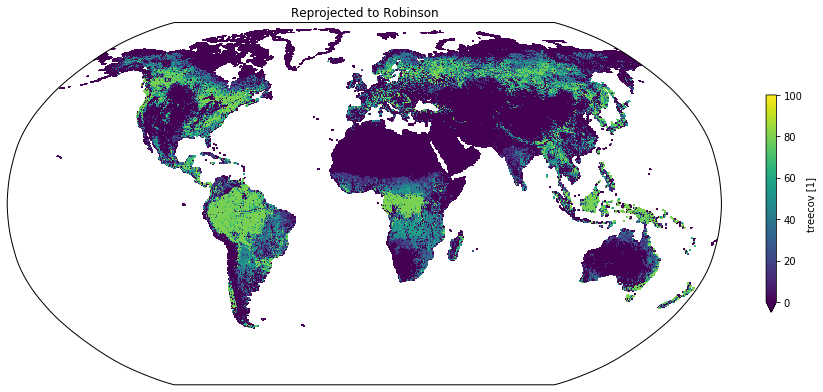

In [52]:
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection=ccrs.Robinson())
treeData.plot(ax=ax, transform=proj,
         vmin=0, vmax=100, cbar_kwargs={'shrink': 0.4}) # notice the cmap argument
plt.title("Reprojected to Robinson")

  | Notice how we used `transform=proj` to tell Python what our data projection was in 

# Meteorological Contour Plots

Download **GFS_20101026_1200.nc** from (https://github.com/jsimkins2/geog473-673/tree/master/datasets)

GFS (Global Forecast System) is one of meteorology's most famous forecast models. Hurricanes, snow storms, thunderstomrs, etc. are all forecasted far out in advance for the entire globe. We'll use a subset of the GFS model to look at some low pressure systems (associated with inclement weather). We're going to explore the heights of  pressure levels (the lower the heights for a pressure level, the lower the pressure). 

In [212]:
gfs = xr.open_dataset("../Datasets/GFS_20101026_1200.nc") #note your path might be "/Users/students/Downloads/GFS_20101026_1200.nc"

In [3]:
gfs

<xarray.Dataset>
Dimensions:                                  (height_above_ground: 1, height_above_ground1: 1, isobaric3: 26, isobaric5: 25, lat: 361, lon: 720, time: 1)
Coordinates:
  * time                                     (time) datetime64[ns] 2010-10-26T12:00:00
  * isobaric3                                (isobaric3) float32 1000.0 ... 100000.0
  * lat                                      (lat) float32 90.0 89.5 ... -90.0
  * lon                                      (lon) float32 0.0 0.5 ... 359.5
  * height_above_ground1                     (height_above_ground1) float32 10.0
  * isobaric5                                (isobaric5) float32 1000.0 ... 100000.0
  * height_above_ground                      (height_above_ground) float32 2.0
Data variables:
    u-component_of_wind_isobaric             (time, isobaric3, lat, lon) float32 ...
    v-component_of_wind_height_above_ground  (time, height_above_ground1, lat, lon) float32 ...
    v-component_of_wind_isobaric             (

#### Explore some dimensions

In [26]:
gfs.time.values

array(['2010-10-26T12:00:00.000000000'], dtype='datetime64[ns]')

In [27]:
gfs.isobaric3

<xarray.DataArray 'isobaric3' (isobaric3: 26)>
array([  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,
        25000.,  30000.,  35000.,  40000.,  45000.,  50000.,  55000.,  60000.,
        65000.,  70000.,  75000.,  80000.,  85000.,  90000.,  92500.,  95000.,
        97500., 100000.], dtype=float32)
Coordinates:
  * isobaric3  (isobaric3) float32 1000.0 2000.0 3000.0 ... 97500.0 100000.0
Attributes:
    units:                   Pa
    long_name:               Isobaric surface
    positive:                down
    Grib_level_type:         100
    _CoordinateAxisType:     Pressure
    _CoordinateZisPositive:  down

**Isobaric3** -  Isobars: lines of constant pressure. A line drawn on a weather map connecting points of equal pressure is called an isobar. The isobars are generated from mean sea level pressure reports and the pressure values are given in millibars. ... Stronger winds are associated with larger gradients in pressure.

#### Get the projection information

In [4]:
getproj = gfs.metpy.parse_cf('Geopotential_height_isobaric')
proj = getproj.metpy.cartopy_crs

#### Generate a quick plot of constant pressure lines 

We do this using `.plot.contour()` on our xarray dataframe. Remember how we used `plot()` before, well `plot.contour()` is another plotting function we can use

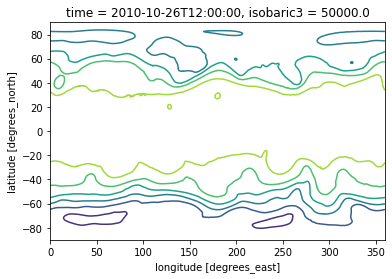

In [5]:
gfs.Geopotential_height_isobaric.sel(isobaric3='50000.', time=str(gfs.time.values[0])).plot.contour()

    | Notice how we are using the sel() function of xarray to declare what time we and isobaric (pressure) level we want. We're able to specify these because they are **dimensions**. 

#### Select the time value and the isobaric dimension

In [213]:
hght_500 = gfs.Geopotential_height_isobaric.sel(time=str(gfs.time.values[0]), isobaric3='50000.')

In [7]:
lats = gfs.variables['lat'][:]
lons = gfs.variables['lon'][:]

In [8]:
lats, lons

(<xarray.IndexVariable 'lat' (lat: 361)>
 array([ 90. ,  89.5,  89. , ..., -89. , -89.5, -90. ], dtype=float32)
 Attributes:
     units:                degrees_north
     _CoordinateAxisType:  Lat
     standard_name:        latitude, <xarray.IndexVariable 'lon' (lon: 720)>
 array([  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5], dtype=float32)
 Attributes:
     units:                degrees_east
     _CoordinateAxisType:  Lon
     standard_name:        longitude)

#### Let's run a gaussian filter (smoothing function) over these lines to make them a little smoother.

In [9]:
Z_500 = ndimage.gaussian_filter(hght_500, sigma=5, order=0)

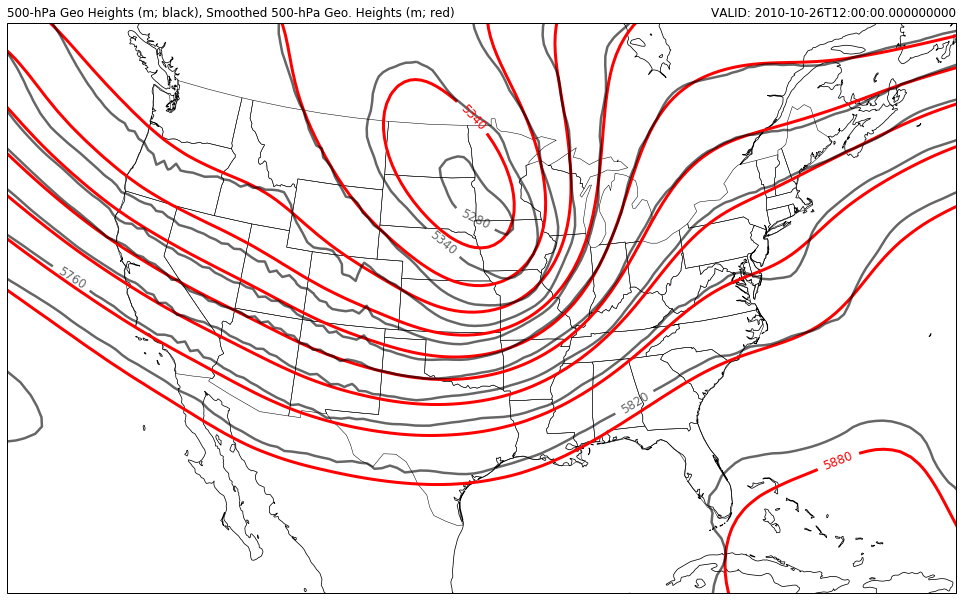

In [10]:
# Start plot with new figure and axis
fig = plt.figure(figsize=(17., 11.))
ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal())

# Add some titles to make the plot readable by someone else
plt.title('500-hPa Geo Heights (m; black), Smoothed 500-hPa Geo. Heights (m; red)',
          loc='left')
plt.title('VALID: {}'.format(gfs.time.values[0]), loc='right')

# Set GAREA and add map features
ax.set_extent([-125., -67., 22., 52.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Set the CINT
clev500 = np.arange(5100, 6000, 60)

# Plot smoothed 500-hPa contours
cs2 = ax.contour(lons, lats, Z_500, clev500, colors='red',
                 linewidths=3, linestyles='solid', transform=proj)
c2 = plt.clabel(cs2, fontsize=12, colors='red', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour the 500 hPa heights with labels
cs = ax.contour(lons, lats, hght_500, clev500, colors='black',
                linewidths=2.5, linestyles='solid', alpha=0.6, transform=proj)
cl = plt.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

#### Let's run through some of the code above that might still be foreign...

| code snippet above | Definition |
|---|---|
| `ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal())` | Declares the axes to be of Lambert Conformal Projection |
| `clev500 = np.arange(5100, 6000, 60)` | Creates a numpy array range from 5100 to 6000 by 60. These are where our contour lines are placed above (aka the level) |
| `cs2 = ax.contour()` | We are plotting a contour plot on our defined axes named `ax` |
| `ax.contour(lons, lats, Z_500, clev500` | lons is our x dimension, lats is our y dimension, Z_500 is our smoothed 500 hPa heights in meters, and clev500 is our numpy array above. |
| `transform=proj` | remember that our data comes in a projection we defined above that is NOT the same as what we declared the projection of our axes to be! |
| `c2 = plt.clabel(cs2` | Plot a colorlabel of `cs2`, which is where the height values show up on the contours like `5880` just east of Florida |

## Adding Temperature to the plot

In [83]:
tmpk_500 = gfs.metpy.parse_cf('Temperature_isobaric').sel(isobaric3='50000.', time=str(gfs.time.values[0]))
tmpk_500

<xarray.DataArray 'Temperature_isobaric' (lat: 361, lon: 720)>
[259920 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2010-10-26T12:00:00
    isobaric3  float32 50000.0
  * lat        (lat) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * lon        (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
    crs        object Projection: latitude_longitude
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-0-0_L100
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               100
    Grib2_Level_Desc:               Isobaric surface
    Grib2_Generating_Process_Type:  Forecast

#### Slicing latitude and longitude to smaller area (area of low pressure system)

We are going to plot temperature as a **filled** contour plot. This means that each grid cell will be filled in, instead of us doing normal contour plot. We'll need to slice our latitude and longitudes to make it smaller due to plotting time. Since Latitude is store backwards, we'll need to slice it from 52 to 30 instead of from 30 to 52

In [84]:
# let's slice our temperature array to make it a little easier to manage
tmpk_500 = tmpk_500.sel(lat=slice(52., 30.), lon=slice(360-120,360-80))
tmpk_500

<xarray.DataArray 'Temperature_isobaric' (lat: 45, lon: 81)>
array([[247.6, 247.7, 247.6, ..., 258.6, 258.3, 257.9],
       [247.5, 247.7, 247.8, ..., 259.1, 258.9, 258.6],
       [247.1, 247. , 247. , ..., 259.5, 259.4, 259.2],
       ...,
       [268.2, 268.1, 268. , ..., 265.8, 265.5, 265.3],
       [268.1, 268. , 268. , ..., 265.6, 265.3, 265.1],
       [268. , 268. , 267.9, ..., 265.5, 265.2, 265. ]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2010-10-26T12:00:00
    isobaric3  float32 50000.0
  * lat        (lat) float32 52.0 51.5 51.0 50.5 50.0 ... 31.5 31.0 30.5 30.0
  * lon        (lon) float32 240.0 240.5 241.0 241.5 ... 278.5 279.0 279.5 280.0
    crs        object Projection: latitude_longitude
Attributes:
    long_name:                      Temperature @ Isobaric surface
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-0-0_L100
    Gri

#### Create pandas dataframe from the xarray dataframe

Then we'll find the maximum and minimum temperatures. These will be used as **vmin** and **vmax** in our filled contour ( `contourf()` ) function as the maximum and minimum values of the coloring

In [211]:
pandas_tmpk_500=tmpk_500.to_pandas()
maxTemp = np.max(pandas_tmpk_500.max())
minTemp = np.min(pandas_tmpk_500.min())

print(maxTemp, minTemp)

269.1 241.9


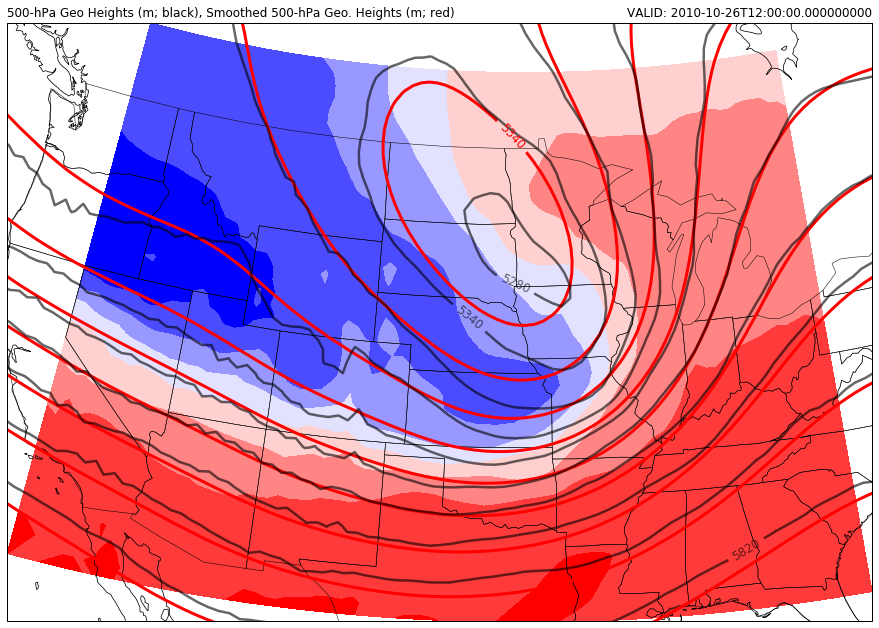

In [94]:
fig = plt.figure(figsize=(17., 11.))
ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal())

# Add some titles to make the plot readable by someone else
plt.title('500-hPa Geo Heights (m; black), Smoothed 500-hPa Geo. Heights (m; red)',
          loc='left')
plt.title('VALID: {}'.format(gfs.time.values[0]), loc='right')

# Set GAREA and add map features
ax.set_extent([-120., -80., 30., 52.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Set the CINT
clev500 = np.arange(5100, 6000, 60)

# Plot smoothed 500-hPa contours
cs2 = ax.contour(lons, lats, Z_500, clev500, colors='red',
                 linewidths=3, linestyles='solid', transform=proj)
c2 = plt.clabel(cs2, fontsize=12, colors='red', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour the 500 hPa heights with labels
cs = ax.contour(lons, lats, hght_500, clev500, colors='black',
                linewidths=2.5, linestyles='solid', alpha=0.6, transform=proj)
cl = plt.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

# Add in temperature data

csf = ax.contourf(tmpk_500.lon.values, tmpk_500.lat.values, tmpk_500, transform=proj, vmin=minTemp, vmax=maxTemp, cmap=plt.cm.bwr)

# Add Wind Barbs to the plot

#### First, let's use metpy to parse the entire gfs xarray dataframe instead of doing it by variable above

In [ ]:
data = gfs.metpy.parse_cf()

Now let's convert our data from m/s (which metpy is already aware of) to knots

In [188]:
data['u-component_of_wind_isobaric'].metpy.convert_units('knot')

data['v-component_of_wind_isobaric'].metpy.convert_units('knot')

Select the height and time value we want (aka the other dimensions of the variables besides lat and lon)

In [ ]:
uwnd_500 = gfs.metpy.parse_cf('u-component_of_wind_isobaric').sel(isobaric3='50000.', time=str(gfs.time.values[0]))
vwnd_500 = gfs.metpy.parse_cf('v-component_of_wind_isobaric').sel(isobaric3='50000.', time=str(gfs.time.values[0]))

Plot it the entire thing again only this time add in the wind barbs! (made possible thanks to MetPy adding the `ax.barbs()` function) 

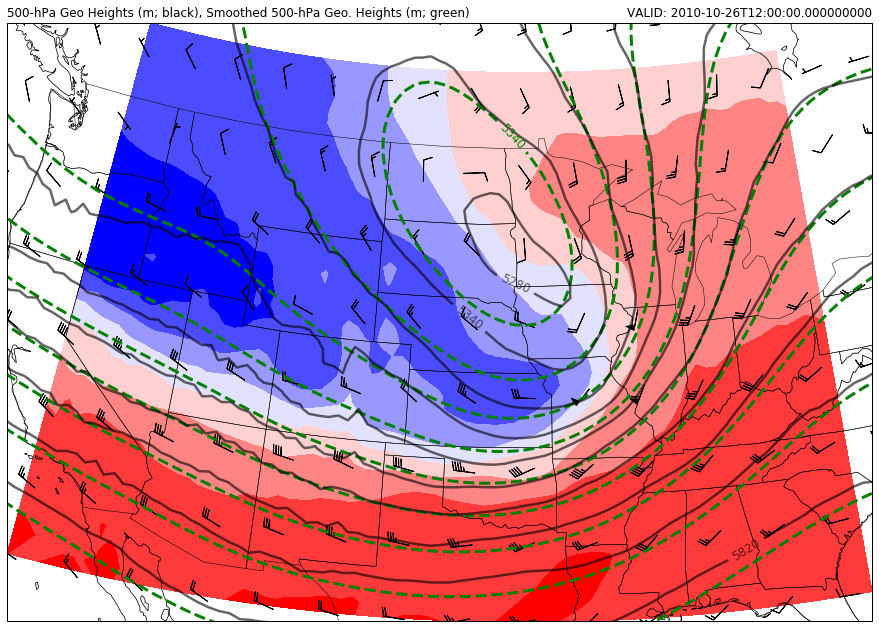

In [210]:
fig = plt.figure(figsize=(17., 11.))
ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal())

# Add some titles to make the plot readable by someone else
plt.title('500-hPa Geo Heights (m; black), Smoothed 500-hPa Geo. Heights (m; green)',
          loc='left')
plt.title('VALID: {}'.format(gfs.time.values[0]), loc='right')

# Set GAREA and add map features
ax.set_extent([-120., -80., 30., 52.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Set the CINT
clev500 = np.arange(5100, 6000, 60)

# Plot smoothed 500-hPa contours
cs2 = ax.contour(lons, lats, Z_500, clev500, colors='green',
                 linewidths=3, linestyles='dashed', transform=proj)

# Add a colorlabel
c2 = plt.clabel(cs2, fontsize=12, colors='green', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour the 500 hPa heights with labels
cs = ax.contour(lons, lats, hght_500, clev500, colors='black',
                linewidths=2.5, linestyles='solid', alpha=0.6, transform=proj)

#Add a colorlabel
cl = plt.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

# Add in temperature data

csf = ax.contourf(tmpk_500.lon.values, tmpk_500.lat.values, tmpk_500, transform=proj, vmin=minTemp, vmax=maxTemp, cmap=plt.cm.bwr)

wind_slice = slice(None, None, 6)
ax.barbs(gfs.lon.values[wind_slice], gfs.lat.values[wind_slice], 
         uwnd_500.values[wind_slice, wind_slice], vwnd_500.values[wind_slice, wind_slice],
         length=6.5,pivot='middle',transform=proj)


plt.savefig("/Users/james/Downloads/metpyExample.png")


# MetPy Assignment - Hurricane Irma

#### Starting with the code below, create a plot as close to the one above as you can. Here's the changes that I want...

- Select any timestamp you want at 85000. gpm (geopotential meter) instead of 50000. gpm like we did above
- Focus the image over Irma
- Edit the title accordingly

**Submit Plot to Canvas - Metpy Assignment**


  | Note that you may need to install `pytest` to read in the dataset - `conda install pytest`

In [194]:
# Open the netCDF file as a xarray Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

# Any import of metpy will activate the accessors
import metpy.calc as mpcalc
from metpy.testing import get_test_data
from metpy.units import units
data = xr.open_dataset(get_test_data('irma_gfs_example.nc', False))

# Parse the entire dataset as a metpy dataset instead of just doing it variable by variable like we did above
data = data.metpy.parse_cf()
# View a summary of the Dataset
print(data)

<xarray.Dataset>
Dimensions:                              (isobaric1: 21, isobaric3: 31, latitude: 81, longitude: 131, time1: 9)
Coordinates:
  * time1                                (time1) datetime64[ns] 2017-09-05T12:00:00 ... 2017-09-06T12:00:00
    reftime                              datetime64[ns] ...
  * latitude                             (latitude) float32 50.0 49.5 ... 10.0
  * isobaric3                            (isobaric3) float64 100.0 ... 1e+05
  * isobaric1                            (isobaric1) float64 1e+04 ... 1e+05
  * longitude                            (longitude) float32 250.0 ... 315.0
Data variables:
    Vertical_velocity_pressure_isobaric  (time1, isobaric1, latitude, longitude) float32 ...
    Relative_humidity_isobaric           (time1, isobaric3, latitude, longitude) float32 ...
    Temperature_isobaric                 (time1, isobaric3, latitude, longitude) float32 ...
    u-component_of_wind_isobaric         (time1, isobaric3, latitude, longitude) floa